In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import page_trend_test
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from statannotations.Annotator import Annotator

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
DRIVER_GENES_PANCAN = "../data/datasets/driver_genes_intogen/Pancancer.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
CLINICAL_DATA = "../data/datasets/PCAWG/clinical_data/pcawg_donor_clinical_data.csv"
SURVIVAL_DATA = "../data/datasets/TCGA_data/TCGA_survival_outcome.csv"
CANCER_PATHWAYS = "../metadata/gene_pathways.csv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files/ directories
OS_ANALYSIS = "../results/OS_pancancer"
OS_CADD_ANALYSIS = "../results/OS_pancancer_CADD"
OS_ANALYSIS_PATHWAY = "../results/OS_pancancer_pathway"

if not os.path.exists(OS_ANALYSIS):
    os.makedirs(OS_ANALYSIS)
if not os.path.exists(OS_CADD_ANALYSIS):
    os.makedirs(OS_CADD_ANALYSIS)
if not os.path.exists(OS_ANALYSIS_PATHWAY):
    os.makedirs(OS_ANALYSIS_PATHWAY)
    
CANCER_TYPES = os.listdir(ANNOTATED_MUTATIONS) # all cancer types
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

37 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Lymph-NOS', 'Myeloid-MPN', 'Cervix-AdenoCA', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Bone-Cart', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Epith', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Breast-DCIS', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Myeloid-MDS', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [5]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [6]:
pancan_driver_genes = pd.read_csv(DRIVER_GENES_PANCAN, sep="\t")
pancan_driver_genes = pancan_driver_genes[["Symbol", "Samples (%)"]]
pancan_driver_genes = pancan_driver_genes[pancan_driver_genes["Samples (%)"] >= 1]
print(pancan_driver_genes.shape)
driver_genes_list = pancan_driver_genes["Symbol"].tolist()

(31, 2)


In [7]:
# get all mutations in driver genes
tumor_mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	print(cancer_type)
	tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	tumor_mut_cancer_df["cancer_type"] = cancer_type
	tumor_mut_df = pd.concat([tumor_mut_df, tumor_mut_cancer_df], ignore_index=True)

# filter for driver genes
print(tumor_mut_df.shape)
tumor_mut_df = tumor_mut_df[tumor_mut_df["gene"].isin(driver_genes_list)]
print(tumor_mut_df.shape)

tumor_mut_df.head()

CNS-Oligo
Kidney-ChRCC
Prost-AdenoCA
Kidney-RCC
Stomach-AdenoCA
CNS-Medullo
Thy-AdenoCA
Lymph-NOS
Myeloid-MPN
Cervix-AdenoCA
Bone-Leiomyo
Lymph-BNHL
Myeloid-AML
Lung-AdenoCA
CNS-GBM
Head-SCC
Breast-AdenoCa
Bone-Cart
Ovary-AdenoCA
CNS-PiloAstro
Cervix-SCC
Liver-HCC
Bone-Epith
Bone-Osteosarc
Biliary-AdenoCA
Skin-Melanoma
Breast-DCIS
Lung-SCC
Lymph-CLL
Panc-Endocrine
Bladder-TCC
Myeloid-MDS
Panc-AdenoCA
ColoRect-AdenoCA
Breast-LobularCa
Eso-AdenoCa
Uterus-AdenoCA
(52663963, 14)
(160040, 14)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,cancer_type
330,FAT3,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,11:92236483-92236483:T:C,11:92236483:T:C,False,None,False,intronic,0.009398,2.007,CNS-Oligo
1036,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:141692891-141692891:T:A,2:141692891:T:A,False,None,False,intronic,0.162961,3.903,CNS-Oligo
1037,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:142843261-142843261:T:C,2:142843261:T:C,False,None,False,intronic,-0.347344,0.346,CNS-Oligo
1083,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.400,CNS-Oligo
1907,EGFR,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,7:55228862-55228862:C:G,7:55228862:C:G,False,None,False,intronic,0.484401,7.718,CNS-Oligo


In [8]:
print(tumor_mut_df.shape)
# filter out samples that are not in the whitelist
tumor_mut_df = tumor_mut_df[tumor_mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(tumor_mut_df.shape)

(160040, 14)
(142168, 14)


In [9]:
# get genome-wide mutation data
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")[["Tumor_Sample_Barcode", "num_drivers"]]
tumor_mut_df = pd.merge(tumor_mut_df, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
print(tumor_mut_df.shape)
tumor_mut_df.head()

(142168, 15)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,cancer_type,num_drivers
0,FAT3,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,11:92236483-92236483:T:C,11:92236483:T:C,False,None,False,intronic,0.009398,2.007,CNS-Oligo,5
1,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:141692891-141692891:T:A,2:141692891:T:A,False,None,False,intronic,0.162961,3.903,CNS-Oligo,5
2,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:142843261-142843261:T:C,2:142843261:T:C,False,None,False,intronic,-0.347344,0.346,CNS-Oligo,5
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.400,CNS-Oligo,5
4,EGFR,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,7:55228862-55228862:C:G,7:55228862:C:G,False,None,False,intronic,0.484401,7.718,CNS-Oligo,5


In [10]:
# get clinical data
clinical_data_df = pd.read_csv(CLINICAL_DATA)
clinical_data_df = clinical_data_df[["icgc_donor_id", "submitted_donor_id", "donor_sex"]]
clinical_data_df = clinical_data_df.rename(columns={
    "icgc_donor_id": "Patient_ID", 
    "submitted_donor_id": "bcr_patient_barcode"
})
clinical_data_df.dropna(inplace=True)
clinical_data_df.drop_duplicates(inplace=True)
print(clinical_data_df.shape)
clinical_data_df.head()

(2809, 3)


,Patient_ID,bcr_patient_barcode,donor_sex
0,DO1000,CGP_donor_1114930,female
1,DO1001,CGP_donor_1069291,female
2,DO1002,CGP_donor_1114881,female
3,DO1003,CGP_donor_1114929,female
4,DO1004,CGP_donor_1167078,female


In [11]:
# get survival outcomes data
survival_data_df = pd.read_csv(SURVIVAL_DATA)
survival_data_df.reset_index(inplace=True)
survival_data_df.drop(columns=["index", "Unnamed: 0"], inplace=True)
print(survival_data_df.shape)
survival_data_df.head()

(11160, 33)


,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2004.0,...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2008.0,...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [12]:
# merge tumor data with clinical data
tumor_data_merged_df = pd.merge(tumor_mut_df, clinical_data_df, on="Patient_ID", how="left")
print(tumor_data_merged_df.shape)
tumor_data_merged_df.head()

(142168, 17)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,cancer_type,num_drivers,bcr_patient_barcode,donor_sex
0,FAT3,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,11:92236483-92236483:T:C,11:92236483:T:C,False,None,False,intronic,0.009398,2.007,CNS-Oligo,5,TCGA-EZ-7264,female
1,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:141692891-141692891:T:A,2:141692891:T:A,False,None,False,intronic,0.162961,3.903,CNS-Oligo,5,TCGA-EZ-7264,female
2,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:142843261-142843261:T:C,2:142843261:T:C,False,None,False,intronic,-0.347344,0.346,CNS-Oligo,5,TCGA-EZ-7264,female
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.400,CNS-Oligo,5,TCGA-EZ-7264,female
4,EGFR,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,7:55228862-55228862:C:G,7:55228862:C:G,False,None,False,intronic,0.484401,7.718,CNS-Oligo,5,TCGA-EZ-7264,female


In [13]:
# merge tumor data with survival data
tumor_survival_data_merged_df = pd.merge(tumor_data_merged_df, survival_data_df, on="bcr_patient_barcode", how="left")
print(tumor_survival_data_merged_df.shape)
tumor_survival_data_merged_df.head()

(142168, 49)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,FAT3,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,11:92236483-92236483:T:C,11:92236483:T:C,False,None,False,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
1,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:141692891-141692891:T:A,2:141692891:T:A,False,None,False,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
2,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:142843261-142843261:T:C,2:142843261:T:C,False,None,False,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
4,EGFR,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,7:55228862-55228862:C:G,7:55228862:C:G,False,None,False,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN


In [14]:
def label_cadd_score(cadd_score):
    if pd.isnull(cadd_score):
        return "no cadd score"
    elif cadd_score <= 0:
        return "low cadd score"
    else:
        return "high cadd score"

# filter out indels and MNVs without CADD scores
print(tumor_survival_data_merged_df.shape)
tumor_survival_data_merged_df_witout_cadd = tumor_survival_data_merged_df[tumor_survival_data_merged_df["CADD_score_raw"].isnull()]
tumor_survival_data_merged_df = tumor_survival_data_merged_df[tumor_survival_data_merged_df["CADD_score_raw"].notnull()]
print(tumor_survival_data_merged_df.shape)

# normalize CADD scores
tumor_survival_data_merged_df["CADD_score_normalized"] = tumor_survival_data_merged_df.groupby("gene")["CADD_score_raw"].transform(lambda x: (x - x.mean()) / x.std())
tumor_survival_data_merged_df = pd.concat([tumor_survival_data_merged_df, tumor_survival_data_merged_df_witout_cadd], ignore_index=True)

# label mutations by cadd score
tumor_survival_data_merged_df["CADD_score_label"] = tumor_survival_data_merged_df["CADD_score_normalized"].apply(label_cadd_score)
tumor_survival_data_merged_df.head()

(142168, 49)
(132180, 49)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,...,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,CADD_score_normalized,CADD_score_label
0,FAT3,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,11:92236483-92236483:T:C,11:92236483:T:C,False,None,False,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,-0.338466,low cadd score
1,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:141692891-141692891:T:A,2:141692891:T:A,False,None,False,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,0.083283,high cadd score
2,LRP1B,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:142843261-142843261:T:C,2:142843261:T:C,False,None,False,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,-0.716998,low cadd score
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,1.737324,high cadd score
4,EGFR,+,Intron,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,7:55228862-55228862:C:G,7:55228862:C:G,False,None,False,...,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN,0.453498,high cadd score


## Overall Survival (OS) analysis

In [15]:
# tumor samples for which we have survival data
tumor_survival_data_merged_df.dropna(subset=["OS", "OS.time"], inplace=True)
print(tumor_survival_data_merged_df.shape)

# mutation density by driver status
tumor_OS_df = tumor_survival_data_merged_df[["Tumor_Sample_Barcode", "gene", "mutation", "driver", "has_driver", "OS", "OS.time", "CADD_score_label", "cancer_type"]]
tumor_OS_df["has_driver"] = tumor_OS_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
tumor_OS_df["has_driver"] = tumor_OS_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)
tumor_OS_mut_density = tumor_OS_df.groupby(["Tumor_Sample_Barcode", "gene", "has_driver"]).agg({
    "mutation": "count",
    "OS": "first",
    "CADD_score_label": lambda x: list(set(x)),
    "OS.time": "first",
    "cancer_type": "first"
}).reset_index()
tumor_OS_mut_density["CADD_score_label"] = tumor_OS_mut_density["CADD_score_label"].apply(lambda x: "high cadd score" if "high cadd score" in x else "low cadd score" if "low cadd score" in x else "no cadd score")
tumor_OS_mut_density.rename(columns={"mutation": "mutation_count"}, inplace=True)
print(tumor_OS_mut_density.shape)
tumor_OS_mut_density = tumor_OS_mut_density[tumor_OS_mut_density["has_driver"] != "Passengers in presence of driver"]
print(tumor_OS_mut_density.shape)
tumor_OS_mut_density.head()

(74166, 51)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_96080/199934857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_OS_df["has_driver"] = tumor_OS_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")


(8394, 8)
(8094, 8)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_96080/199934857.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_OS_df["has_driver"] = tumor_OS_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)


,Tumor_Sample_Barcode,gene,has_driver,mutation_count,OS,CADD_score_label,OS.time,cancer_type
0,00493087-9d9d-40ca-86d5-936f1b951c93,BRAF,Passengers in absence of driver,1,0.0,low cadd score,1201.0,CNS-Oligo
1,00493087-9d9d-40ca-86d5-936f1b951c93,CSMD3,Passengers in absence of driver,2,0.0,high cadd score,1201.0,CNS-Oligo
2,00493087-9d9d-40ca-86d5-936f1b951c93,EGFR,Passengers in absence of driver,1,0.0,high cadd score,1201.0,CNS-Oligo
3,00493087-9d9d-40ca-86d5-936f1b951c93,FAT3,Passengers in absence of driver,1,0.0,low cadd score,1201.0,CNS-Oligo
4,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Drivers,1,0.0,high cadd score,1201.0,CNS-Oligo


In [16]:
# list of all tumor samples for which we have survival data
tumor_list = tumor_OS_mut_density["Tumor_Sample_Barcode"].unique().tolist()
print(f"Number of tumor samples for which we have survival data: {len(tumor_list)}")

# list of all genes
gene_list = tumor_OS_mut_density["gene"].unique().tolist()
print(f"Number of genes: {len(gene_list)}")

# create a map of survival data for each tumor
tumor_survival_map = {}
for index, row in tumor_OS_mut_density.iterrows():
    tumor_survival_map[row["Tumor_Sample_Barcode"]] = {
        "OS": row["OS"],
        "OS.time": row["OS.time"]
    }
print(len(tumor_survival_map), tumor_survival_map)

# create a map of mutation counts for each tumor-gene-has_driver combination
tumor_gene_has_driver_map = {}
for index, row in tumor_OS_mut_density.iterrows():
    tumor_gene_has_driver_map[(row["Tumor_Sample_Barcode"], row["gene"], row["has_driver"], row["CADD_score_label"])] = {
        "mutation_count": row["mutation_count"]
    }
print(len(tumor_gene_has_driver_map), tumor_gene_has_driver_map)

Number of tumor samples for which we have survival data: 790
Number of genes: 31
790 {'00493087-9d9d-40ca-86d5-936f1b951c93': {'OS': 0.0, 'OS.time': 1201.0}, '007aab66-2f07-459d-8952-3041d6ea24a8': {'OS': 0.0, 'OS.time': 1148.0}, '00aa769d-622c-433e-8a8a-63fb5c41ea42': {'OS': 0.0, 'OS.time': 255.0}, '00bf0350-8c7c-4b9e-8143-13ea2dc1122f': {'OS': 0.0, 'OS.time': 617.0}, '00db4dc2-3ec7-4ff9-9233-d69c8c8a607f': {'OS': 0.0, 'OS.time': 776.0}, '01658141-8398-4585-9f0f-8355dd9b0604': {'OS': 0.0, 'OS.time': 1925.0}, '0176cf1d-0760-4769-a493-277f4bb7585e': {'OS': 1.0, 'OS.time': 303.0}, '0192d529-7340-45d8-a5f0-249cbb11ca19': {'OS': 0.0, 'OS.time': 531.0}, '020fab36-c7de-4933-b2bf-dc7b019a1326': {'OS': 0.0, 'OS.time': 842.0}, '02c6a893-49c5-49d1-8eb1-195021e70d52': {'OS': 0.0, 'OS.time': 1521.0}, '0332b017-17d5-4083-8fc4-9d6f8fdbbbde': {'OS': 0.0, 'OS.time': 470.0}, '0385961e-ea99-40b2-ad79-6872bc30d8a1': {'OS': 0.0, 'OS.time': 2554.0}, '03c88506-d72e-4a44-a34e-a7f0564f1799': {'OS': 1.0, 'OS.t

In [17]:
tumor_gene_driver_data = []
for tumor in tumor_list:
    cancer_type = tumor_survival_data_merged_df[tumor_survival_data_merged_df["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
    for gene in gene_list:
        if (tumor, gene, "Drivers", "low cadd score") in tumor_gene_has_driver_map or (tumor, gene, "Drivers", "high cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
        elif (tumor, gene, "Passengers in absence of driver", "low cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has passengers with low cadd scores but no drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
        elif (tumor, gene, "Passengers in absence of driver", "high cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has passengers with high cadd scores but no drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
        elif (tumor, gene, "Passengers in absence of driver", "no cadd score") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
				"Tumor_Sample_Barcode": tumor,
				"gene": gene,
				"mutation_status": "Has passengers but no drivers",
				"OS": tumor_survival_map[tumor]["OS"],
				"OS.time": tumor_survival_map[tumor]["OS.time"],
				"cancer_type": cancer_type
			})
        else:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has no mutations",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type
            })
tumor_gene_driver_data = pd.DataFrame(tumor_gene_driver_data)
print(tumor_gene_driver_data.shape)
tumor_gene_driver_data.head()

(24490, 6)


,Tumor_Sample_Barcode,gene,mutation_status,OS,OS.time,cancer_type
0,00493087-9d9d-40ca-86d5-936f1b951c93,BRAF,Has passengers with low cadd scores but no dri...,0.0,1201.0,CNS-Oligo
1,00493087-9d9d-40ca-86d5-936f1b951c93,CSMD3,Has passengers with high cadd scores but no dr...,0.0,1201.0,CNS-Oligo
2,00493087-9d9d-40ca-86d5-936f1b951c93,EGFR,Has passengers with high cadd scores but no dr...,0.0,1201.0,CNS-Oligo
3,00493087-9d9d-40ca-86d5-936f1b951c93,FAT3,Has passengers with low cadd scores but no dri...,0.0,1201.0,CNS-Oligo
4,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Has drivers,0.0,1201.0,CNS-Oligo


## Pancancer Analysis

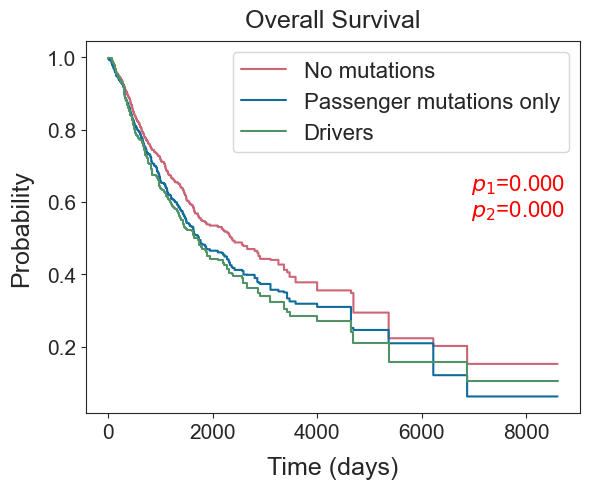

In [18]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_driver_data.copy()

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(6, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"]
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.6, rf"$\it{{p}}_1$={p_value1:.3f}",
		transform=plt.gca().transAxes, fontsize=16, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.53, rf"$\it{{p}}_2$={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=16, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=18)
plt.xlabel('Time (days)', labelpad=10, fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=16, loc='upper right')
plt.title("Overall Survival", fontsize=18, pad=10)
plt.tight_layout()

## Analysis for Tumor Supressor Genes and Oncogenes

In [19]:
tumor_gene_type_driver_data = tumor_gene_driver_data.copy()
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)
cancer_gene_type = cancer_gene_type[["Hugo Symbol", "type"]]
cancer_gene_type.columns = ["gene", "type"]
print(tumor_gene_type_driver_data.shape)
tumor_gene_type_driver_data = pd.merge(tumor_gene_type_driver_data, cancer_gene_type, on="gene", how="left")
print(tumor_gene_type_driver_data.shape)
tumor_gene_type_driver_data.head()

(24490, 6)
(24490, 7)


,Tumor_Sample_Barcode,gene,mutation_status,OS,OS.time,cancer_type,type
0,00493087-9d9d-40ca-86d5-936f1b951c93,BRAF,Has passengers with low cadd scores but no dri...,0.0,1201.0,CNS-Oligo,OG
1,00493087-9d9d-40ca-86d5-936f1b951c93,CSMD3,Has passengers with high cadd scores but no dr...,0.0,1201.0,CNS-Oligo,NaN
2,00493087-9d9d-40ca-86d5-936f1b951c93,EGFR,Has passengers with high cadd scores but no dr...,0.0,1201.0,CNS-Oligo,OG
3,00493087-9d9d-40ca-86d5-936f1b951c93,FAT3,Has passengers with low cadd scores but no dri...,0.0,1201.0,CNS-Oligo,NaN
4,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Has drivers,0.0,1201.0,CNS-Oligo,OG


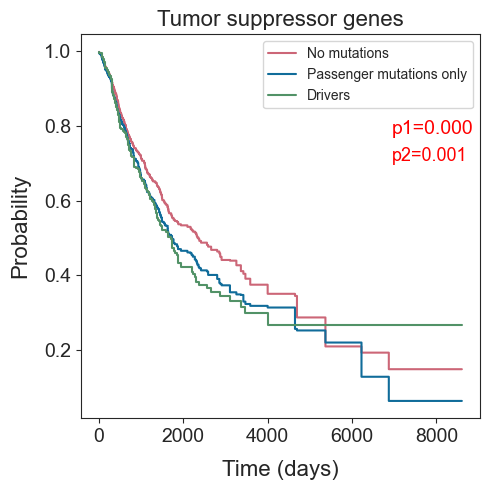

In [20]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_type_driver_data[tumor_gene_type_driver_data["type"] == "TSG"]

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(5, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"]
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.74, f"p1={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=14, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.67, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=13, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=16)
plt.xlabel('Time (days)', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Tumor suppressor genes", fontsize=16)
plt.tight_layout()

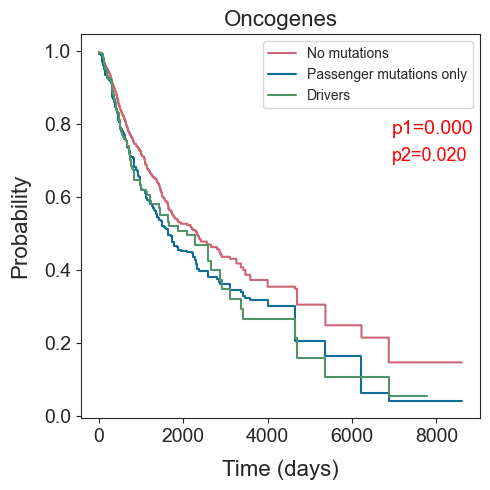

In [21]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_type_driver_data[tumor_gene_type_driver_data["type"] == "OG"]

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(5, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
categories = ["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"]
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.74, f"p1={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=14, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.67, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=13, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=16)
plt.xlabel('Time (days)', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Oncogenes", fontsize=16)
plt.tight_layout()

## Median survival across all genes

In [22]:
results = []
groups = [["Has no mutations"],
		["Has passengers with low cadd scores but no drivers", "Has passengers with high cadd scores but no drivers"],
		["Has drivers"]]
labels = ["No mutations", "Passenger mutations only", "Drivers"]

# get max duration
max_time = 0

for gene in driver_genes_list:
	tumor_gene_has_driver_data_selected = tumor_gene_driver_data[tumor_gene_driver_data["gene"] == gene]
	for i, group in enumerate(groups):
		group_df = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(group)]
		max_time = max(max_time, group_df["OS.time"].max())
		if len(group_df) == 0:
			continue
		kmf = KaplanMeierFitter()
		kmf.fit(group_df["OS.time"], group_df["OS"], label='No mutations')
		median = kmf.median_survival_time_
		results.append({
			'gene': gene,
			'group': labels[i],
			'median_survival': median,
			'type': tumor_gene_type_driver_data[tumor_gene_type_driver_data["gene"] == gene]["type"].values[0],
		})
results_df = pd.DataFrame(results)
results_df['median_survival'] = results_df['median_survival'].replace(np.inf, max_time)
results_df.head()

,gene,group,median_survival,type
0,TP53,No mutations,2419.0,TSG
1,TP53,Passenger mutations only,4648.0,TSG
2,TP53,Drivers,1768.0,TSG
3,KRAS,No mutations,2379.0,OG
4,KRAS,Passenger mutations only,1124.0,OG


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No mutations vs. Passenger mutations only: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:2.453e-07 U_stat=8.380e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



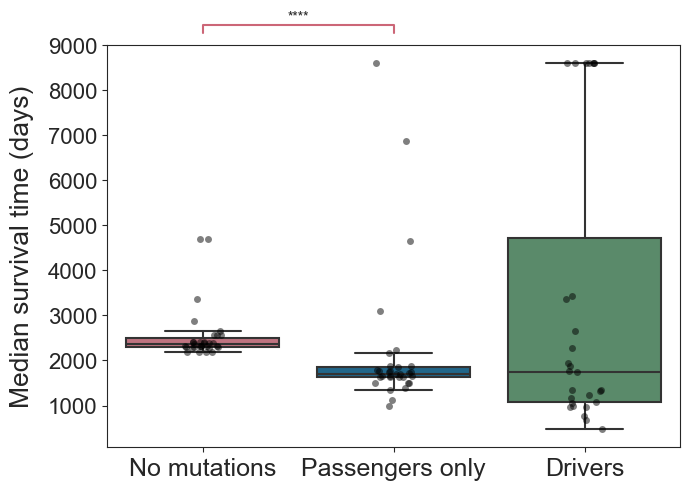

In [23]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=results_df, 
    x='group', 
    y='median_survival',
    order=labels,
    showfliers=False,
    palette=cmap,
)
sns.stripplot(
	data=results_df, 
	x='group', 
	y='median_survival',
	order=labels,
	color='black',
	alpha=0.5,
	size=5,
)

# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=results_df, 
    x="group",
    y="median_survival", 
    pairs=[(labels[0], labels[1]), (labels[1], labels[2])],
    order=labels,
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xticks(ticks=[0, 1, 2], \
	labels=["No mutations", "Passengers only", "Drivers"], fontsize=18)
plt.xlabel('')
plt.yticks(fontsize=16)
plt.ylabel('Median survival time (days)', fontsize=19, labelpad=10)
plt.tight_layout()
plt.savefig("../results/median_survival_time_pancancer.pdf", bbox_inches='tight')

In [24]:
results = []

groups = tumor_gene_driver_data["mutation_status"].unique().tolist()
groups.remove("Has passengers but no drivers")
print(groups)
labels = ["No mutations", "Low CADD score passengers only", "High CADD score passengers only", "Drivers"]

# get max duration
max_time = 0

for gene in driver_genes_list:
	tumor_gene_has_driver_data_selected = tumor_gene_driver_data[tumor_gene_driver_data["gene"] == gene]
	for i, group in enumerate(groups):
		group_df = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == group]
		max_time = max(max_time, group_df["OS.time"].max())
		if len(group_df) == 0:
			continue
		kmf = KaplanMeierFitter()
		kmf.fit(group_df["OS.time"], group_df["OS"], label='No mutations')
		median = kmf.median_survival_time_
		results.append({
			'gene': gene,
			'group': labels[i],
			'median_survival': median,
			'type': tumor_gene_type_driver_data[tumor_gene_type_driver_data["gene"] == gene]["type"].values[0],
		})
results_df = pd.DataFrame(results)
results_df['median_survival'] = results_df['median_survival'].replace(np.inf, max_time)
results_df.head()

['Has passengers with low cadd scores but no drivers', 'Has passengers with high cadd scores but no drivers', 'Has drivers', 'Has no mutations']


,gene,group,median_survival,type
0,TP53,No mutations,4648.0,TSG
1,TP53,High CADD score passengers only,1768.0,TSG
2,TP53,Drivers,2419.0,TSG
3,KRAS,No mutations,1124.0,OG
4,KRAS,Low CADD score passengers only,474.0,OG


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No mutations vs. Low CADD score passengers only: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:5.422e-03 U_stat=6.420e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



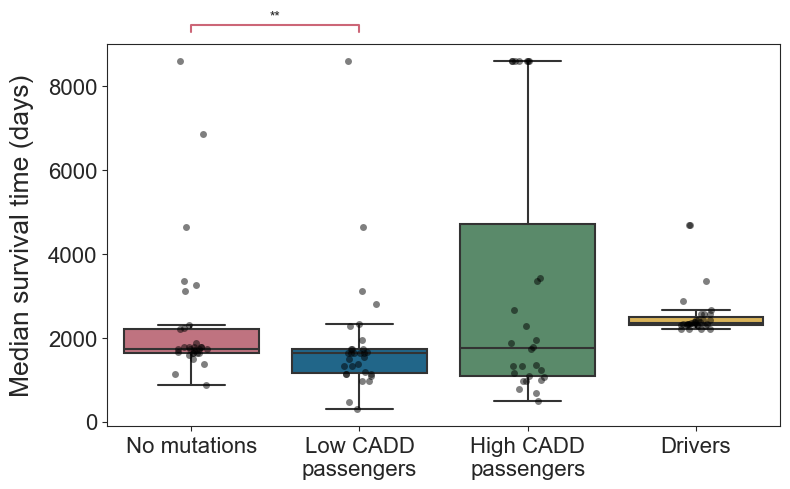

In [25]:
plt.figure(figsize=(8, 5))

ax = sns.boxplot(
    data=results_df, 
    x='group', 
    y='median_survival',
    order=labels,
    showfliers=False,
    palette=cmap,
)
sns.stripplot(
	data=results_df, 
	x='group', 
	y='median_survival',
	order=labels,
	color='black',
	alpha=0.5,
	size=5,
)

# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=results_df, 
    x="group",
    y="median_survival", 
    pairs=[(labels[0], labels[1]), (labels[1], labels[2]), (labels[2], labels[3])],
    order=labels,
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xticks(ticks=[0, 1, 2, 3], \
	labels=["No mutations", "Low CADD\npassengers", "High CADD\npassengers", "Drivers"], fontsize=16)
plt.xlabel('')
plt.yticks(fontsize=16)
plt.ylabel('Median survival time (days)', fontsize=19, labelpad=10)
plt.tight_layout()

## Survival Analysis by number of passenger mutations

In [26]:
missing_rows = []
print(tumor_OS_mut_density.shape)
for tumor in tumor_list:
	cancer_type = tumor_OS_mut_density[tumor_OS_mut_density["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
	for gene in gene_list:
		if tumor_OS_mut_density[(tumor_OS_mut_density["Tumor_Sample_Barcode"] == tumor) & (tumor_OS_mut_density["gene"] == gene)].shape[0] == 0:
			missing_rows.append({
				"Tumor_Sample_Barcode": tumor,
				"gene": gene,
				"has_driver": "Has no mutations",
				"OS": tumor_survival_map[tumor]["OS"],
				"OS.time": tumor_survival_map[tumor]["OS.time"],
				"cancer_type": cancer_type
			})
missing_rows = pd.DataFrame(missing_rows)
print(len(missing_rows))
tumor_OS_mut_density = pd.concat([tumor_OS_mut_density, missing_rows], ignore_index=True)
print(tumor_OS_mut_density.shape)
tumor_OS_mut_density.head()

(8094, 8)
16396
(24490, 8)


,Tumor_Sample_Barcode,gene,has_driver,mutation_count,OS,CADD_score_label,OS.time,cancer_type
0,00493087-9d9d-40ca-86d5-936f1b951c93,BRAF,Passengers in absence of driver,1.0,0.0,low cadd score,1201.0,CNS-Oligo
1,00493087-9d9d-40ca-86d5-936f1b951c93,CSMD3,Passengers in absence of driver,2.0,0.0,high cadd score,1201.0,CNS-Oligo
2,00493087-9d9d-40ca-86d5-936f1b951c93,EGFR,Passengers in absence of driver,1.0,0.0,high cadd score,1201.0,CNS-Oligo
3,00493087-9d9d-40ca-86d5-936f1b951c93,FAT3,Passengers in absence of driver,1.0,0.0,low cadd score,1201.0,CNS-Oligo
4,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Drivers,1.0,0.0,high cadd score,1201.0,CNS-Oligo


In [27]:
gene_data = tumor_OS_mut_density[tumor_OS_mut_density["has_driver"] == "Passengers in absence of driver"]
gene_data = gene_data[["gene", "mutation_count"]]
gene_data = gene_data.groupby("gene").agg({
	"mutation_count": lambda x: list(x)
}).reset_index()
gene_data["quartlies"] = gene_data["mutation_count"].apply(lambda x: np.percentile(x, [0, 25, 50, 75, 100]))
gene_data.head()

,gene,mutation_count,quartlies
0,APC,"[1.0, 1.0, 5.0, 1.0, 8.0, 1.0, 3.0, 3.0, 1.0, ...","[1.0, 1.0, 1.0, 2.0, 27.0]"
1,ARID1A,"[4.0, 1.0, 7.0, 10.0, 1.0, 1.0, 7.0, 1.0, 4.0,...","[1.0, 1.0, 1.0, 2.0, 29.0]"
2,ARID2,"[5.0, 1.0, 1.0, 7.0, 1.0, 1.0, 13.0, 1.0, 2.0,...","[1.0, 1.0, 1.0, 2.0, 125.0]"
3,ATM,"[2.0, 1.0, 1.0, 2.0, 13.0, 7.0, 22.0, 1.0, 2.0...","[1.0, 1.0, 1.0, 2.0, 22.0]"
4,BRAF,"[1.0, 6.0, 1.0, 1.0, 3.0, 4.0, 3.0, 10.0, 12.0...","[1.0, 1.0, 1.0, 2.0, 139.0]"


In [28]:
def get_quartile(row):
	if row["has_driver"] == "Drivers" or row["has_driver"] == "Has no mutations":
		return row["has_driver"]
	gene = row["gene"]
	mutation_count = row["mutation_count"]
	gene_quartiles = gene_data[gene_data["gene"] == gene]["quartlies"].values[0]
	if mutation_count <= gene_quartiles[1]:
		return "Low"
	elif mutation_count > gene_quartiles[1] and mutation_count <= gene_quartiles[3]:
		return "Medium"
	else:
		return "High"

In [29]:
tumor_OS_mut_density["group"] = tumor_OS_mut_density.apply(lambda x: get_quartile(x), axis=1)
tumor_OS_mut_density.head()

,Tumor_Sample_Barcode,gene,has_driver,mutation_count,OS,CADD_score_label,OS.time,cancer_type,group
0,00493087-9d9d-40ca-86d5-936f1b951c93,BRAF,Passengers in absence of driver,1.0,0.0,low cadd score,1201.0,CNS-Oligo,Low
1,00493087-9d9d-40ca-86d5-936f1b951c93,CSMD3,Passengers in absence of driver,2.0,0.0,high cadd score,1201.0,CNS-Oligo,Low
2,00493087-9d9d-40ca-86d5-936f1b951c93,EGFR,Passengers in absence of driver,1.0,0.0,high cadd score,1201.0,CNS-Oligo,Low
3,00493087-9d9d-40ca-86d5-936f1b951c93,FAT3,Passengers in absence of driver,1.0,0.0,low cadd score,1201.0,CNS-Oligo,Low
4,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Drivers,1.0,0.0,high cadd score,1201.0,CNS-Oligo,Drivers


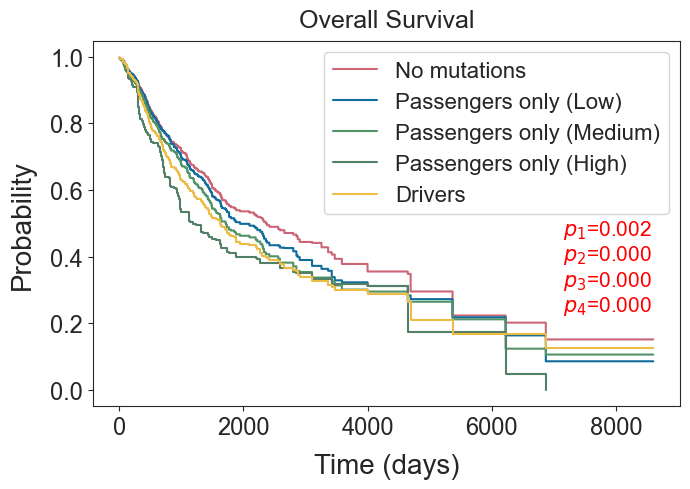

In [30]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#528067", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_OS_mut_density.copy()

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(7, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "low number of passenger mutations"
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Low"]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passengers only (Low)')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.8, 0.47, rf"$\it{{p}}_1$={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=15, color=color1)

# "no mutations" vs "medium number of passenger mutations"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Medium"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Passengers only (Medium)')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.8, 0.40, rf"$\it{{p}}_2$={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=15, color=color3)
	
# "no mutations" vs "high number of passenger mutations"
group3 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "High"]
if len(group3) > 0:
	kmf_exp3 = KaplanMeierFitter()
	kmf_exp3_result = kmf_exp3.fit(group3["OS.time"], group3["OS"], label='Passengers only (High)')
	kmf_exp3_result.plot_survival_function(color=cmap[3], ci_show=False)
	results3 = logrank_test(group0['OS.time'], group3['OS.time'], event_observed_A=group0['OS'], event_observed_B=group3['OS'])
	p_value3 = results3.p_value
	color4 = 'red' if p_value3 < 0.05 else 'black'
	plt.text(0.8, 0.33, rf"$\it{{p}}_3$={p_value3:.3f}", 
			transform=plt.gca().transAxes, fontsize=15, color=color4)
	
# "no mutations" vs "drivers"
group4 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Drivers"]
if len(group4) > 0:
	kmf_exp4 = KaplanMeierFitter()
	kmf_exp4_result = kmf_exp4.fit(group4["OS.time"], group4["OS"], label='Drivers')
	kmf_exp4_result.plot_survival_function(color=cmap[4], ci_show=False)
	results4 = logrank_test(group0['OS.time'], group4['OS.time'], event_observed_A=group0['OS'], event_observed_B=group4['OS'])
	p_value4 = results4.p_value
	color5 = 'red' if p_value4 < 0.05 else 'black'
	plt.text(0.8, 0.26, rf"$\it{{p}}_4$={p_value4:.3f}", 
			transform=plt.gca().transAxes, fontsize=15, color=color5)

plt.ylabel('Probability', labelpad=10, fontsize=20)
plt.xlabel('Time (days)', labelpad=10, fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=16, loc='upper right')
plt.title("Overall Survival", fontsize=18, pad=10)
plt.tight_layout()

## Median survival by number of passengers

In [ ]:
plot_data = []
groups = tumor_OS_mut_density["group"].unique().tolist()

# get max duration
max_time = 0

for gene in driver_genes_list:
	tumor_gene_has_driver_data_selected = tumor_OS_mut_density[tumor_OS_mut_density["gene"] == gene]
	for i, group in enumerate(groups):
		group_df = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == group]
		max_time = max(max_time, group_df["OS.time"].max())
		if len(group_df) == 0:
			continue
		kmf = KaplanMeierFitter()
		kmf.fit(group_df["OS.time"], group_df["OS"], label='No mutations')
		median = kmf.median_survival_time_
		plot_data.append({
			'gene': gene,
			'group': group,
			'median_survival': median,
			'type': tumor_gene_type_driver_data[tumor_gene_type_driver_data["gene"] == gene]["type"].values[0],
		})
plot_data_df = pd.DataFrame(plot_data)
plot_data_df['median_survival'] = plot_data_df['median_survival'].replace(np.inf, max_time)
plot_data_df.head()

,gene,group,median_survival,type
0,TP53,Low,6225.0,TSG
1,TP53,Drivers,1711.0,TSG
2,TP53,High,8605.0,TSG
3,TP53,Medium,659.0,TSG
4,TP53,Has no mutations,2907.0,TSG


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Has no mutations vs. Low: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:8.383e-05 U_stat=7.480e+02
Low vs. Medium: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:1.224e-03 U_stat=5.925e+02
Medium vs. High: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:8.732e-03 U_stat=5.515e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



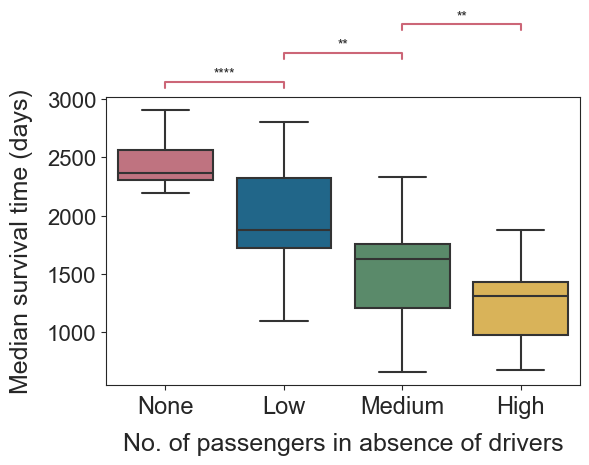

In [46]:
plt.figure(figsize=(6, 5))

order = ["Has no mutations", "Low", "Medium", "High"]
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

ax = sns.boxplot(
    data=plot_data_df, 
    x='group', 
    y='median_survival',
    order=order,
    showfliers=False,
    palette=cmap
)

# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=plot_data_df, 
    x="group",
    y="median_survival", 
    pairs=[(order[0], order[1]), (order[1], order[2]), (order[2], order[3])],
    order=order,
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xticks(ticks=[0, 1, 2, 3], \
	labels=["None", "Low", "Medium", "High"], fontsize=17)
plt.xlabel("No. of passengers in absence of drivers", fontsize=18, labelpad=10)
plt.yticks(fontsize=16)
plt.ylabel('Median survival time (days)', fontsize=18, labelpad=10)
plt.tight_layout()

In [ ]:
# save group and median data for performing Jonckheere-Terpstra test
plot_data_df = plot_data_df[plot_data_df["group"] != "Drivers"]
plot_data_df[["group", "median_survival"]].to_csv("../results/median_survival_time_pancancer_groups.csv", index=False)